# MIMIC Preprocessed EDA

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from recurrent_health_events_prediction.visualization.utils import plot_patients_hospitalizations
from recurrent_health_events_prediction.eda.utils import compare_distributions
from recurrent_health_events_prediction.model.model_types import DistributionType

event_type_censoring_color_map = {
    "Event Ocurred": px.colors.qualitative.Plotly[1],
    "Censored": px.colors.qualitative.Plotly[0]
}

event_type_color_map = {
    'Hosp. with Readmission after Discharge': px.colors.qualitative.Plotly[0],
    'Hosp. with In-Hospital Death': px.colors.qualitative.Plotly[1],
    'Hosp. with Death After Hospital Discharge': px.colors.qualitative.Plotly[2],
    'Hosp. with No Readmission or No Death after Discharge': px.colors.qualitative.Plotly[4]
}

MULTIPLE_HOSP_PATIENTS = True

### Import Data

In [2]:
from importlib import resources as impresources
from recurrent_health_events_prediction import configs
import yaml

with open((impresources.files(configs) / 'data_config.yaml')) as f:
    data_config = yaml.safe_load(f)

In [3]:
training_data_config = data_config["training_data"]["mimic"]
training_data_path = training_data_config["preprocessed_output_path_1st_round"]
if MULTIPLE_HOSP_PATIENTS:
    training_data_path += '/multiple_hosp_patients'
print(f"Loading training data from {training_data_path}")

Loading training data from /workspaces/msc-thesis-recurrent-health-modeling/data/mimic-iii-preprocessed/copd_hf_renal_diabetes/multiple_hosp_patients


In [4]:
all_events_patient_plot_df = pd.read_csv(training_data_path+ "/all_events.csv")
all_events_patient_plot_df['ADMITTIME'] = pd.to_datetime(all_events_patient_plot_df['ADMITTIME'])
all_events_patient_plot_df['DISCHTIME'] = pd.to_datetime(all_events_patient_plot_df['DISCHTIME'])
all_events_patient_plot_df['DOD'] = pd.to_datetime(all_events_patient_plot_df['DOD'])

In [5]:
all_events_df = pd.read_csv(training_data_path + "/all_events.csv")
all_events_df['ADMITTIME'] = pd.to_datetime(all_events_df['ADMITTIME'])
all_events_df['DISCHTIME'] = pd.to_datetime(all_events_df['DISCHTIME'])
all_events_df['DOD'] = pd.to_datetime(all_events_df['DOD'])

In [6]:
all_events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5951 entries, 0 to 5950
Data columns (total 57 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   SUBJECT_ID                            5951 non-null   int64         
 1   HADM_ID                               5951 non-null   int64         
 2   ADMITTIME                             5951 non-null   datetime64[ns]
 3   DISCHTIME                             5951 non-null   datetime64[ns]
 4   ADMISSION_TYPE                        5951 non-null   object        
 5   ETHNICITY                             5951 non-null   object        
 6   DISCHARGE_LOCATION                    5951 non-null   object        
 7   INSURANCE                             5951 non-null   object        
 8   HOSPITALIZATION_DAYS                  5951 non-null   float64       
 9   NUM_COMORBIDITIES                     5951 non-null   int64         
 10  

In [7]:
last_events_df = pd.read_csv(training_data_path + "/last_events.csv")
last_events_df['ADMITTIME'] = pd.to_datetime(last_events_df['ADMITTIME'])
last_events_df['DISCHTIME'] = pd.to_datetime(last_events_df['DISCHTIME'])
last_events_df['DOD'] = pd.to_datetime(last_events_df['DOD'])

In [8]:
historical_events_df = all_events_df[all_events_df['IS_HISTORICAL_EVENT'] == 1].copy()

In [9]:
def classify_event(row):
    if row['READMISSION_EVENT'] == 1:
        return 'Hosp. with Readmission after Discharge'
    elif row['IN_HOSP_DEATH_EVENT'] == 1:
        return 'In-Hospital Death'
    elif row['AFTER_HOSP_DEATH_EVENT'] == 1:
        return 'Hosp. with Death After Hospital Discharge'
    else:
        return 'Hosp. with No Readmission or No Death after Discharge'

all_events_df['EVENT_TYPE'] = all_events_df.apply(classify_event, axis=1)
last_events_df['EVENT_TYPE'] = last_events_df.apply(classify_event, axis=1)
all_events_patient_plot_df['EVENT_TYPE'] = all_events_patient_plot_df.apply(classify_event, axis=1)
historical_events_df['EVENT_TYPE'] = historical_events_df.apply(classify_event, axis=1)

In [10]:
print("Number of unique subjects in all_events_df: ", all_events_df["SUBJECT_ID"].nunique())
print("Number of unique subjects in last_events_df: ", last_events_df["SUBJECT_ID"].nunique())
print("Number of unique subjects in historical_events_df: ", historical_events_df["SUBJECT_ID"].nunique())

Number of unique subjects in all_events_df:  1878
Number of unique subjects in last_events_df:  1878
Number of unique subjects in historical_events_df:  1878


### Checking data consistency

In [11]:
last_events_df[["EVENT_DURATION", "READMISSION_EVENT", "NUM_PREV_HOSPITALIZATIONS"]].describe()

,EVENT_DURATION,READMISSION_EVENT,NUM_PREV_HOSPITALIZATIONS
count,1878.000000,1878.000000,1878.000000
mean,78.610586,0.507987,2.168797
std,46.827454,0.500069,2.348385
min,1.004167,0.000000,1.000000
25%,28.313194,0.000000,1.000000
50%,115.147917,1.000000,1.000000
75%,120.000000,1.000000,2.000000
max,120.000000,1.000000,40.000000


In [12]:
assert all_events_df["EVENT_DURATION"].min() >= 0, "Event durations should be non-negative."
assert all_events_df["PARTICIPATION_DAYS"].min() >= 0, "Participation days should be non-negative."
assert all_events_df["TOTAL_PARTICIPATION_DAYS"].min() >= 0, "Total participation days should be non-negative."
assert all_events_df["PARTICIPATION_DAYS"].max() <= all_events_df["TOTAL_PARTICIPATION_DAYS"].max(), "Participation days should not exceed total participation days."
assert all_events_df["EVENT_DURATION"].max() <= training_data_config["censoring_limit"], "Event duration should not exceed upper limit."

### Inspect Patient History

In [13]:
subject_id = 433
plot_patients_hospitalizations(
    all_events_patient_plot_df,
    subject_ids=[323, 357, 402, 433, 518],
    additional_hover_cols=[
        "EVENT_TYPE",
        "DAYS_UNTIL_NEXT_HOSPITALIZATION",
        "TYPES_COMORBIDITIES",
        "ADMISSION_TYPE",
        "TOTAL_HOSPITALIZATIONS",
    ],
    color_map=event_type_color_map,
    color_col="EVENT_TYPE",
)
mask = all_events_df["SUBJECT_ID"] == subject_id
all_events_df[mask]

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ETHNICITY,DISCHARGE_LOCATION,INSURANCE,HOSPITALIZATION_DAYS,NUM_COMORBIDITIES,...,LOG_HOSPITALIZATION_DAYS,LOG_DAYS_IN_ICU,LOG_NUM_PREV_HOSPITALIZATIONS,LOG_PARTICIPATION_DAYS,LOG_NUM_DRUGS,IS_LAST_EVENT,IS_HISTORICAL_EVENT,READMISSION_TIME_CAT,READMISSION_TIME_CAT_ENCODED,EVENT_TYPE
57,433,120589,2162-01-18 11:32:00,2162-02-08 18:55:00,EMERGENCY,BLACK/AFRICAN AMERICAN,REHAB/DISTINCT PART HOSP,Medicaid,21.307639,2,...,3.104929,1.630891,0.000000,3.091042,3.806662,0,1,120+,2,Hosp. with No Readmission or No Death after Di...
58,433,141626,2163-10-08 15:51:00,2163-10-28 19:52:00,EMERGENCY,BLACK/AFRICAN AMERICAN,REHAB/DISTINCT PART HOSP,Medicaid,20.167361,3,...,3.052460,2.193862,0.693147,6.475433,3.784190,0,1,120+,2,Hosp. with No Readmission or No Death after Di...
59,433,172593,2164-03-06 20:55:00,2164-04-11 11:50:00,EMERGENCY,BLACK/AFRICAN AMERICAN,HOME HEALTH CARE,Medicaid,35.621528,4,...,3.600636,1.650820,1.098612,6.703188,3.970292,1,0,120+,2,Hosp. with No Readmission or No Death after Di...


## All Events

In [14]:
print("Number of subjects: ", all_events_df["SUBJECT_ID"].nunique())

Number of subjects:  1878


### Distribution of Readmission Time Category

In [15]:
px.pie(
    all_events_df,
    names="READMISSION_TIME_CAT",
    title="Distribution of Readmission Time Categories (Days)",
    labels={"READMISSION_TIME_CAT": "Readmission Time Category"},
    color_discrete_sequence=px.colors.qualitative.Plotly,
    height=400,
    width=600,
).show()

### Distribution of Admisison Type

In [16]:
px.pie(
    all_events_df,
    names="ADMISSION_TYPE",
    title=f"Admission Type Proportions",
    labels={"ADMISSION_TYPE": "Admission Type"},
    color_discrete_sequence=px.colors.qualitative.Plotly,
    height=400,
    width=600
).show()

### Diseases Distribution

In [17]:
fig = px.histogram(all_events_df, x='NUM_COMORBIDITIES', title='Distribution of Number of Comorbidities - All Readmission Events', width=800, height=400, nbins=50)
fig.update_layout(xaxis_title='Number of Comorbidities', yaxis_title='Count')
fig.show()

In [18]:
diseases_all_events_df = all_events_df[['SUBJECT_ID', 'TYPES_COMORBIDITIES']].copy()
diseases_all_events_df.head()

,SUBJECT_ID,TYPES_COMORBIDITIES
0,36,"['other', 'chronic_pulmonary_disease']"
1,36,"['other', 'chronic_pulmonary_disease']"
2,107,"['other', 'renal_disease']"
3,107,"['other', 'congestive_heart_failure', 'myocard..."
4,124,"['other', 'chronic_pulmonary_disease', 'cerebr..."


In [19]:
from sklearn.preprocessing import MultiLabelBinarizer
import ast

# If your column is still strings, convert to list first
diseases_all_events_df['TYPES_COMORBIDITIES'] = diseases_all_events_df['TYPES_COMORBIDITIES'].apply(ast.literal_eval)

# Now one-hot encode the comorbidities
mlb = MultiLabelBinarizer()
disease_ohe = mlb.fit_transform(diseases_all_events_df['TYPES_COMORBIDITIES'])

# Create a DataFrame with patient IDs as index and disease columns
disease_df = pd.DataFrame(disease_ohe, 
                          columns=mlb.classes_, 
                          index=diseases_all_events_df['SUBJECT_ID'])

# Now you can see the matrix you described
disease_df.head()

,aids,cerebrovascular_disease,chronic_pulmonary_disease,congestive_heart_failure,dementia,diabetes_with_cc,diabetes_without_cc,malignant_cancer,metastatic_solid_tumor,mild_liver_disease,myocardial_infarct,other,paraplegia,peptic_ulcer_disease,peripheral_vascular_disease,renal_disease,rheumatic_disease,severe_liver_disease
SUBJECT_ID,,,,,,,,,,,,,,,,,,
36,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
36,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
107,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
107,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0
124,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [20]:
disease_counts = disease_df.sum().sort_values(ascending=False)

px.bar(disease_counts,
    title='Total Number of Patients with Each Disease - All Readmission Events',
    labels={'index': 'Disease', 'value': 'Number of Patients'},
    width=1200,
    height=400
).update_layout(xaxis_title='Disease', yaxis_title='Number of Patients').show()

### Distribution of Event Types

In [21]:
px.pie(
       all_events_df,
       names='EVENT_TYPE',
       title='Distribution of Event Types in All Events',
       color='EVENT_TYPE',
       width=800,
       height=400,
       color_discrete_map=event_type_color_map
).show()

In [22]:
fig = px.pie(all_events_df["READMISSION_EVENT"].map(lambda x: "Event Ocurred" if x == 1 else "Censored"),
       names='READMISSION_EVENT',
       title='Proportion of Censored Readmission Events in All Events',
       color='READMISSION_EVENT',
       labels={'READMISSION_EVENT': 'Observed Readmission'},
       width=800,
       height=400,
       color_discrete_map=event_type_censoring_color_map)
# Display the figure
fig.show()

### Distribution of Participation Days

In [23]:
participation_df = all_events_df.groupby("SUBJECT_ID")[["TOTAL_PARTICIPATION_DAYS", "EVENT_TYPE", "NUM_PREV_HOSPITALIZATIONS"]].last().reset_index()
participation_df.head()

,SUBJECT_ID,TOTAL_PARTICIPATION_DAYS,EVENT_TYPE,NUM_PREV_HOSPITALIZATIONS
0,36,1116,Hosp. with No Readmission or No Death after Di...,1
1,107,2643,Hosp. with No Readmission or No Death after Di...,1
2,124,2047,Hosp. with No Readmission or No Death after Di...,2
3,138,858,Hosp. with Readmission after Discharge,1
4,188,1831,Hosp. with Readmission after Discharge,5


In [24]:
participation_df["TOTAL_PARTICIPATION_DAYS"].describe()

count    1878.000000
mean     1250.861022
std       975.941425
min        26.000000
25%       432.750000
50%      1007.000000
75%      1902.750000
max      4225.000000
Name: TOTAL_PARTICIPATION_DAYS, dtype: float64

In [25]:
participation_days_binned_count_s = pd.cut(
    participation_df["TOTAL_PARTICIPATION_DAYS"],
    right=True,
    bins=[0, 180, 365, 730, 1460, np.inf],
    labels=["0--180 days", "181--365 days", "1--2 years", "2--4 years", "4+ years"]
).value_counts(normalize=True).sort_index() * 100

participation_days_binned_count_s = participation_days_binned_count_s.reset_index()
participation_days_binned_count_s.columns = ["Participation Days", "Percentage"]
participation_days_binned_count_s

,Participation Days,Percentage
0,0--180 days,11.022364
1,181--365 days,10.436635
2,1--2 years,17.944622
3,2--4 years,24.866880
4,4+ years,35.729499


In [26]:
overall_median_participation_days = participation_df["TOTAL_PARTICIPATION_DAYS"].median()
num_participants_less_than_30_days = (participation_df["TOTAL_PARTICIPATION_DAYS"] < 30).sum()
num_participants_less_than_10_days = (participation_df["TOTAL_PARTICIPATION_DAYS"] < 10).sum()
print(f"Number of participants with less than 30 days of participation: {num_participants_less_than_30_days}")
print(f"Overall median participation days: {overall_median_participation_days}")
print(f"Number of participants with less than 10 days of participation: {num_participants_less_than_10_days}")

Number of participants with less than 30 days of participation: 4
Overall median participation days: 1007.0
Number of participants with less than 10 days of participation: 0


In [27]:
fig = px.histogram(participation_df, "TOTAL_PARTICIPATION_DAYS", nbins=80)
fig.update_layout(
    title="Distribution of Participation Time in the Study",
    width=1000,
    height=400,
    bargap=0.05,
)
fig.update_xaxes(title_text="Total Participation Days", dtick=100, )
fig.update_yaxes(title_text="Number of Patients")
fig.show()

In [28]:
fig = px.histogram(participation_df, "TOTAL_PARTICIPATION_DAYS", facet_col="EVENT_TYPE", nbins=50, color="EVENT_TYPE", color_discrete_map=event_type_color_map)
fig.update_layout(
    title="Distribution of Estimated Participation Time in the Study"
)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

#### Examples - Short Total Participation Days

In [29]:
subjects_ids = [29080, 88254, 63442, 1547, 3871]


In [30]:
plot_patients_hospitalizations(all_events_df, subject_ids=subjects_ids,
                               additional_hover_cols=['EVENT_TYPE', 'NUM_PREV_HOSPITALIZATIONS', 'DAYS_UNTIL_NEXT_HOSPITALIZATION'],
                               color_map=event_type_color_map, color_col='EVENT_TYPE', max_number_days=30)

### Distribution of Event Duration

#### Observed Readmissions

In [31]:
all_observed_readmissions_df = all_events_df[all_events_df["READMISSION_EVENT"] == 1]
all_observed_readmissions_df["EVENT_DURATION"].describe()

count    2982.000000
mean       38.953366
std        31.892476
min         1.004167
25%        11.611111
50%        29.932292
75%        60.463715
max       119.997222
Name: EVENT_DURATION, dtype: float64

In [32]:
import plotly.express as px

fig = px.histogram(all_observed_readmissions_df, x='EVENT_DURATION', title='Distribution of Time to Observed Readmissions', width=1200, height=400)
fig.update_layout(xaxis_title='Time to Readmission Event', yaxis_title='Count')
fig.show()

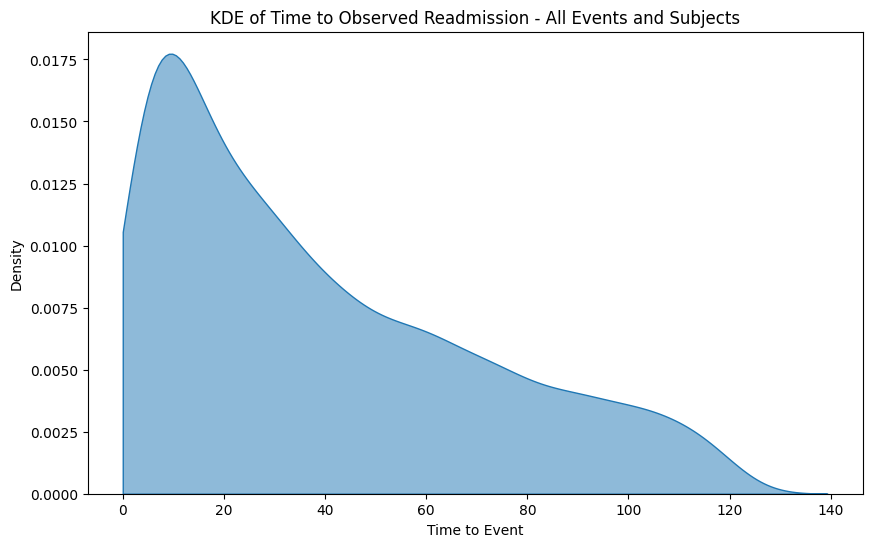

In [33]:
all_observed_readmissions_df = all_events_df[all_events_df["READMISSION_EVENT"] == 1]
plt.figure(figsize=(10, 6))

sns.kdeplot(data=all_observed_readmissions_df, x='EVENT_DURATION', alpha=0.5, fill=True, clip=(0, None))

plt.title('KDE of Time to Observed Readmission - All Events and Subjects')
plt.xlabel('Time to Event')
plt.ylabel('Density')
plt.show()

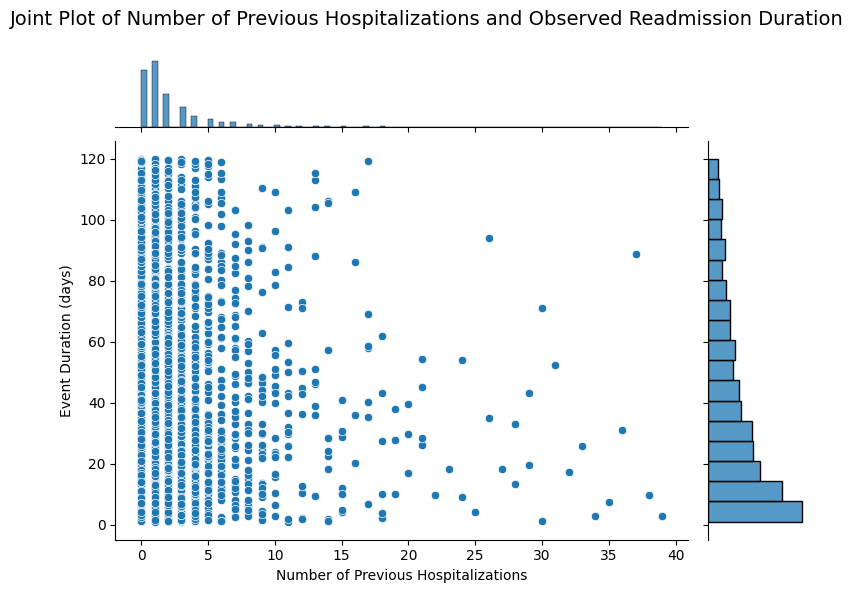

In [34]:
sns.jointplot(
    data=all_observed_readmissions_df,
    x='NUM_PREV_HOSPITALIZATIONS',
    y='EVENT_DURATION',
)
plt.gcf().set_size_inches(8, 6)
plt.suptitle('Joint Plot of Number of Previous Hospitalizations and Observed Readmission Duration', fontsize=14)
plt.subplots_adjust(top=0.9)
plt.xlabel('Number of Previous Hospitalizations')
plt.ylabel('Event Duration (days)')
plt.show()

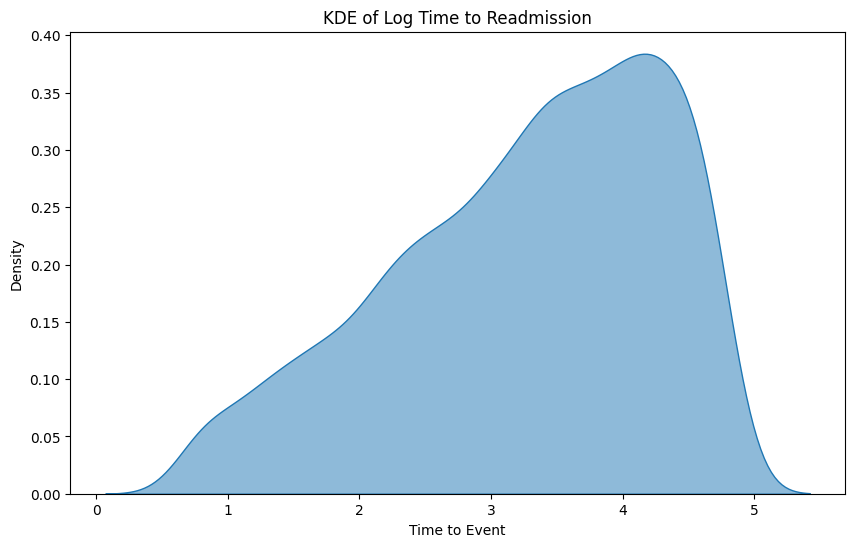

In [35]:
log_duration_readmission_s = np.log1p(all_observed_readmissions_df['EVENT_DURATION'])
plt.figure(figsize=(10, 6))

sns.kdeplot(data=log_duration_readmission_s, alpha=0.5, fill=True)

plt.title('KDE of Log Time to Readmission')
plt.xlabel('Time to Event')
plt.ylabel('Density')
plt.show()

In [36]:
from scipy.stats import normaltest, shapiro
stat_normaltest, p_normaltest = normaltest(log_duration_readmission_s)  # D’Agostino and Pearson’s test
stat_shapiro, p_shapiro = shapiro(log_duration_readmission_s)           # Shapiro-Wilk test

print(f"Normaltest p-value: {p_normaltest}")
print(f"Shapiro-Wilk p-value: {p_shapiro}")

Normaltest p-value: 4.435853247090255e-49
Shapiro-Wilk p-value: 1.8822834344017625e-30


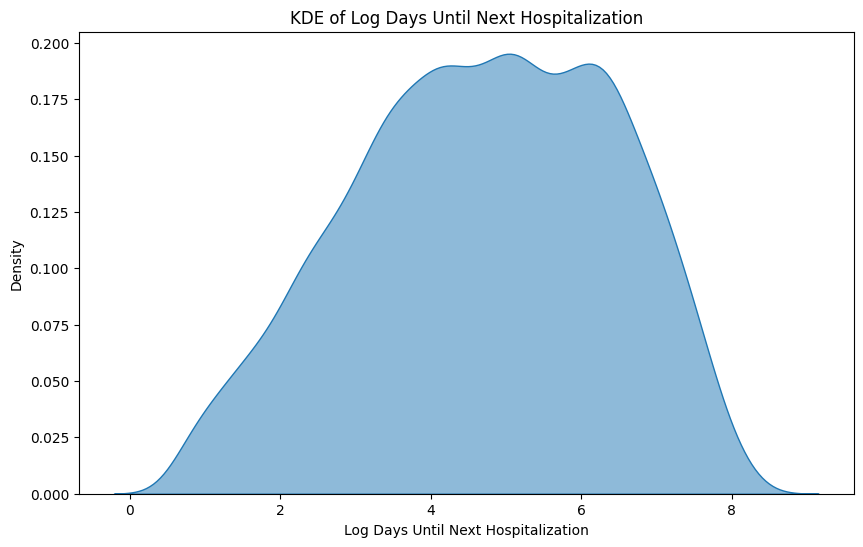

In [37]:
all_events_time_until_next_hosp_df = all_events_df[all_events_df["LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION"].notna()]
plt.figure(figsize=(10, 6))
sns.kdeplot(data=all_events_time_until_next_hosp_df, alpha=0.5, fill=True, x='LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION')
plt.title('KDE of Log Days Until Next Hospitalization')
plt.xlabel('Log Days Until Next Hospitalization')
plt.ylabel('Density')
plt.show()

In [38]:
log_days_until_next_hospitalization_s = all_events_time_until_next_hosp_df["LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION"]

--- Fit Comparison for Log Days Until Next Hospitalization ---


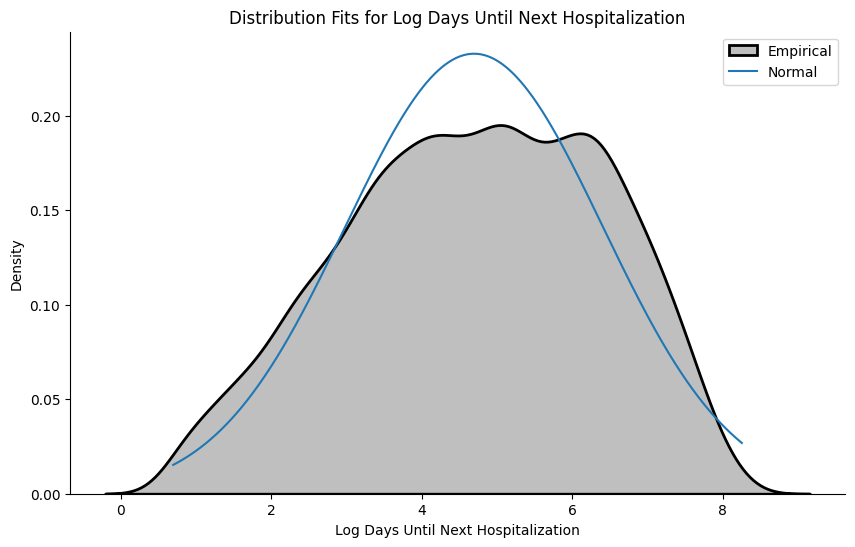

,aic,bic,loglik,ks_stat,ks_pvalue
normal,23296.538675,23309.921304,-11646.269338,0.04637,0.0


In [39]:
compare_distributions(log_days_until_next_hospitalization_s, 
                      [DistributionType.NORMAL],
                      var_name="Log Days Until Next Hospitalization")

In [40]:
from scipy.stats import normaltest, shapiro
stat_normaltest, p_normaltest = normaltest(log_days_until_next_hospitalization_s)  # D’Agostino and Pearson’s test
stat_shapiro, p_shapiro = shapiro(log_days_until_next_hospitalization_s)           # Shapiro-Wilk test

print(f"Normaltest p-value: {p_normaltest}")
print(f"Shapiro-Wilk p-value: {p_shapiro}")

Normaltest p-value: 8.454812936248576e-105
Shapiro-Wilk p-value: 1.1244776173776195e-26


/home/vscode/poetry-venvs/recurrent-health-events-prediction-nvorhdTT-py3.10/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5951.



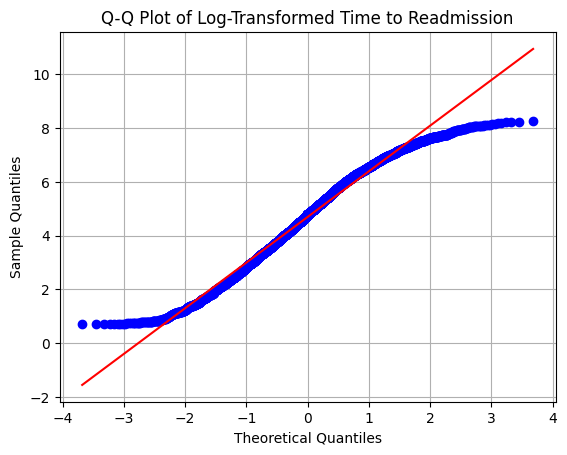

In [41]:
import scipy.stats as stats

stats.probplot(log_days_until_next_hospitalization_s, dist="norm", plot=plt)
plt.title("Q-Q Plot of Log-Transformed Time to Readmission")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid(True)
plt.show()

### Distribution of Number of Previous Events

In [42]:
count_all_events_per_subject_df = all_events_df.groupby('SUBJECT_ID').agg(TOTAL_NUM_HOSPITALIZATIONS=('HADM_ID', 'nunique')).reset_index()

In [43]:
event_type_proportions_df = all_events_df.groupby('NUM_PREV_HOSPITALIZATIONS')['EVENT_TYPE'].value_counts(normalize=True).rename('Proportion').reset_index()
event_type_counts_df = all_events_df.groupby('NUM_PREV_HOSPITALIZATIONS')['EVENT_TYPE'].value_counts().rename('Total Number Events').reset_index()

event_type_proportions_df = event_type_proportions_df.merge(event_type_counts_df, on=('NUM_PREV_HOSPITALIZATIONS', 'EVENT_TYPE'))

fig = px.bar(
       event_type_proportions_df,
       x='NUM_PREV_HOSPITALIZATIONS',
       y='Proportion',
       color='EVENT_TYPE',
       title='Proportion of Event Types by Number of Previous Hospitalizations',
       labels={'Proportion': 'Proportion of Event Type', 'NUM_PREV_HOSPITALIZATIONS': 'Number of Previous Hospitalizations', 'EVENT_TYPE': 'Event Type'},
       color_discrete_map=event_type_color_map,
       text='Total Number Events'  # Add text annotations
)
fig.update_layout(
    height=500,
    bargap=0.2,
    xaxis=dict(tickmode='linear', dtick=1)
)

fig.show()


## Last Events

In [44]:
last_events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1878 entries, 0 to 1877
Data columns (total 58 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   SUBJECT_ID                            1878 non-null   int64         
 1   HADM_ID                               1878 non-null   int64         
 2   ADMITTIME                             1878 non-null   datetime64[ns]
 3   DISCHTIME                             1878 non-null   datetime64[ns]
 4   ADMISSION_TYPE                        1878 non-null   object        
 5   ETHNICITY                             1878 non-null   object        
 6   DISCHARGE_LOCATION                    1878 non-null   object        
 7   INSURANCE                             1878 non-null   object        
 8   HOSPITALIZATION_DAYS                  1878 non-null   float64       
 9   NUM_COMORBIDITIES                     1878 non-null   int64         
 10  

In [45]:
print("Number of subjects: ", last_events_df["SUBJECT_ID"].nunique())
print("Number of events: ", len(last_events_df))

Number of subjects:  1878
Number of events:  1878


### Target Variable Distribution

In [46]:
last_readmissions_observed_df = last_events_df[last_events_df["DAYS_UNTIL_NEXT_HOSPITALIZATION"].notna()]

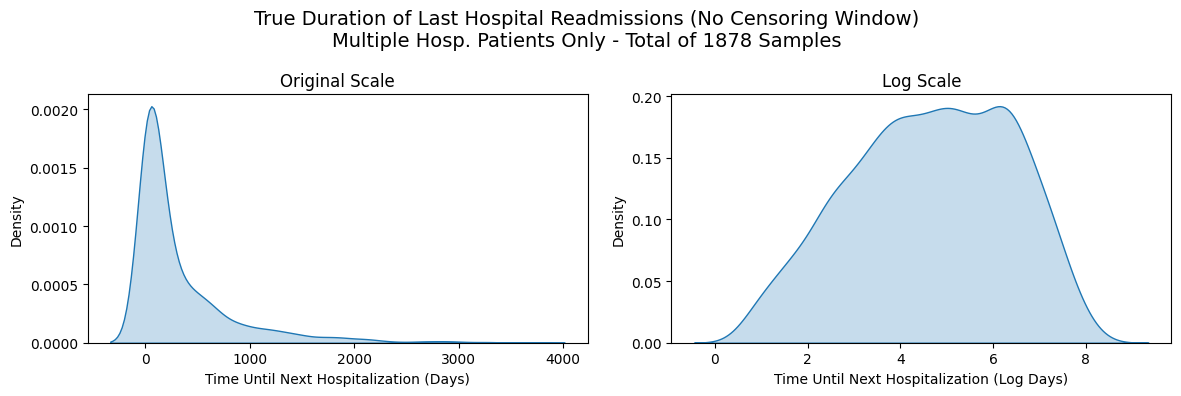

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Original plot
sns.kdeplot(last_readmissions_observed_df['DAYS_UNTIL_NEXT_HOSPITALIZATION'], fill=True, ax=axes[0])
axes[0].set_title("Original Scale")
axes[0].set_xlabel("Time Until Next Hospitalization (Days)")
axes[0].set_ylabel("Density")

# Log-transformed plot
sns.kdeplot(np.log1p(last_readmissions_observed_df['DAYS_UNTIL_NEXT_HOSPITALIZATION']), fill=True, ax=axes[1])
axes[1].set_title("Log Scale")
axes[1].set_xlabel("Time Until Next Hospitalization (Log Days)")
axes[1].set_ylabel("Density")
num_samples = len(last_readmissions_observed_df)
plt.suptitle(f"True Duration of Last Hospital Readmissions (No Censoring Window)\nMultiple Hosp. Patients Only - Total of {len(last_readmissions_observed_df)} Samples", fontsize=14)
plt.tight_layout()
#plt.savefig("last_readmissions_observed_df_kde_plots.png", dpi=500)
plt.show()

In [48]:
import plotly.express as px

mask = (last_events_df["READMISSION_EVENT"] == 1)
fig = px.histogram(
    last_events_df[mask],
    x="EVENT_DURATION",
    title="Distribution of Last Readmission Durations",
    subtitle=f"Multiple Hosp. Patients Only ({len(last_events_df[mask])} samples). Only Readmissions within 120 Days (Non-censored)",
    color_discrete_sequence=px.colors.qualitative.Plotly,
    nbins=120//5,
    range_x=[0, 120],
    width=800,
    height=400
)

fig.update_layout(
    xaxis_title="Readmission Duration (Days)",
    yaxis_title="Number of Readmissions",
    bargap=0.2,
    yaxis={"dtick": 10},
    xaxis={"dtick": 5, "range": [0, 120]}
)
#fig.write_html("last_readmission_duration_distribution.html")
fig.show()

### Distribution of Admisison Type

In [49]:
px.pie(
    last_events_df,
    names="ADMISSION_TYPE",
    title=f"Admission Type Proportions",
    labels={"ADMISSION_TYPE": "Admission Type"},
    color_discrete_sequence=px.colors.qualitative.Plotly,
    height=400,
    width=600
).show()

### Distribution of Readmission Time Category

In [50]:
fig = px.pie(
    last_events_df,
    names="READMISSION_TIME_CAT",
    title="Distribution of Readmission Event Time Categories with Censoring - Last Events <br>Multiple Hosp. Patients Only",
    labels={"READMISSION_TIME_CAT": "Event Time Category"},
    color_discrete_sequence=px.colors.qualitative.Plotly,
    height=400,
    width=800,
)

# Add values as text labels within the pie chart and set text color to white
fig.update_traces(
    textinfo='percent+value',
    textfont=dict(color='white')
)
fig.update_legends(
    title_text='Readmission Time Category (Days)',
    font=dict(size=12)
)
fig.show()

### Events Types

In [51]:
event_type_proportions_df = last_events_df.groupby('NUM_PREV_HOSPITALIZATIONS')['EVENT_TYPE'].value_counts(normalize=True).rename('Proportion').reset_index()
event_type_counts_df = last_events_df.groupby('NUM_PREV_HOSPITALIZATIONS')['EVENT_TYPE'].value_counts().rename('Total Number Events').reset_index()

event_type_proportions_df = event_type_proportions_df.merge(event_type_counts_df, on=('NUM_PREV_HOSPITALIZATIONS', 'EVENT_TYPE'))

fig = px.bar(
       event_type_proportions_df,
       x='NUM_PREV_HOSPITALIZATIONS',
       y='Proportion',
       color='EVENT_TYPE',
       title='Proportion of Event Types by Number of Previous Hospitalizations',
       labels={'Proportion': 'Proportion', 'NUM_PREV_HOSPITALIZATIONS': 'Number of Previous Hospitalizations', 'EVENT_TYPE': 'Event Type'},
       category_orders={'EVENT_TYPE': ['Readmission after Discharge', 'No Readmission or No Death after Discharge']},
       color_discrete_map=event_type_color_map,
       text='Total Number Events'  # Add text annotations
)
fig.update_layout(height=500, bargap=0.2,
    xaxis=dict(tickmode='linear', dtick=1))  # Position the text at the top of the bars

fig.show()

In [52]:
fig = px.histogram(
    data_frame=last_events_df,
    x='NUM_PREV_HOSPITALIZATIONS',
    color='EVENT_TYPE',
    title='Distribution of Number of Previous Hospitalizations by Event Type',
    color_discrete_map=event_type_color_map,
    barmode='group'
)
fig.show()

### Number of Previous Events

In [53]:
last_events_prev_hosp_per_patient_df = last_events_df.groupby('SUBJECT_ID').first().reset_index()[['SUBJECT_ID', 'NUM_PREV_HOSPITALIZATIONS', 'READMISSION_EVENT']]
value_counts_df = last_events_prev_hosp_per_patient_df[['NUM_PREV_HOSPITALIZATIONS', 'READMISSION_EVENT']].value_counts().reset_index()

In [54]:
last_events_prev_hosp_per_patient_df["label"] = np.where(last_events_prev_hosp_per_patient_df['READMISSION_EVENT'] == 1, 'Readmission within 120 Days', 'No Readmission within 120 Days')
fig = px.histogram(
    last_events_prev_hosp_per_patient_df,
    x='NUM_PREV_HOSPITALIZATIONS',
    facet_col='label',
    title='Count of Num. Prev. Hosp. before Last Readmissions Events',
    labels={'NUM_PREV_HOSPITALIZATIONS': 'Number of Previous Hospitalizations', 'label': ''},
    width=800,
    height=400,
    color_discrete_sequence=px.colors.qualitative.Plotly,
)
fig.update_layout(
    yaxis_title='Count',
    bargap=0.05,
)

# Remove '=' from subplot titles
fig.for_each_annotation(lambda a: a.update(text=a.text.split('=')[-1]))
# fig.for_each_yaxis(lambda yaxis: yaxis.update(dtick=50))
fig.for_each_xaxis(lambda xaxis: xaxis.update(dtick=2))


fig.show()

In [55]:
max_num_prev_hosp = last_events_prev_hosp_per_patient_df['NUM_PREV_HOSPITALIZATIONS'].max().item()
print(f"Maximum number of previous hospitalizations: {max_num_prev_hosp}")

Maximum number of previous hospitalizations: 40


In [56]:
count_prev_hosp_s = last_events_prev_hosp_per_patient_df.groupby('NUM_PREV_HOSPITALIZATIONS')["SUBJECT_ID"].count()
count_prev_hosp_s.name = 'Number of Patients'
count_prev_hosp_s

NUM_PREV_HOSPITALIZATIONS
1     1003
2      414
3      212
4       96
5       46
6       28
7       24
8       13
9       12
10       8
11       5
12       4
13       1
14       1
15       3
17       1
18       1
19       1
20       1
21       1
22       1
32       1
40       1
Name: Number of Patients, dtype: int64

In [57]:
# compute counts, percent and cumulative percent for number of previous hospitalizations
counts = last_events_prev_hosp_per_patient_df['NUM_PREV_HOSPITALIZATIONS'].value_counts().sort_index()
percent = counts / counts.sum() * 100
cum_percent = percent.cumsum()

cum_df = pd.DataFrame({
    'NUM_PREV_HOSPITALIZATIONS': counts.index,
    'Count': counts.values,
    'Percent (%)': percent.values,
    'Cumulative Percent (%)': cum_percent.values
}).reset_index(drop=True)

cum_df


,NUM_PREV_HOSPITALIZATIONS,Count,Percent (%),Cumulative Percent (%)
0,1,1003,53.407881,53.407881
1,2,414,22.044728,75.452609
2,3,212,11.288605,86.741214
3,4,96,5.111821,91.853035
4,5,46,2.449414,94.302449
5,6,28,1.490948,95.793397
6,7,24,1.277955,97.071353
7,8,13,0.692226,97.763578
8,9,12,0.638978,98.402556
9,10,8,0.425985,98.828541


In [58]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# prepare x and series
x = cum_df['NUM_PREV_HOSPITALIZATIONS'].astype(str)
percent = cum_df['Percent (%)']
cum = cum_df['Cumulative Percent (%)']

# create 1x2 subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("Cumulative Percent (%)", "Individual Percent (%)"))

# left: cumulative line
fig.add_trace(
    go.Scatter(
        x=x,
        y=cum,
        mode='lines+markers',
        name='Cumulative Percent (%)',
        marker=dict(color=px.colors.qualitative.Plotly[1]),
        line=dict(width=2),
        hovertemplate='%{x}<br>Cumulative: %{y:.2f}%<extra></extra>'
    ),
    row=1, col=1
)

# annotate cumulative values on left
for xi, yi in zip(x, cum):
    if int(xi) > 4:
        continue
    if int(xi) == 4:
        ax_offset = 40
        ay_offset = 5
    else:
        ax_offset = 40
        ay_offset = 5
    fig.add_annotation(
        x=xi, y=yi, xref='x1', yref='y1',
        text=f"{yi:.1f}%", showarrow=True, arrowhead=1, ax=ax_offset, ay=ay_offset, font=dict(size=14)
    )

# right: individual percentages as bars
fig.add_trace(
    go.Bar(
        x=x,
        y=percent,
        name='Percent (%)',
        marker_color=px.colors.qualitative.Plotly[0],
        hovertemplate='%{x}<br>Percent: %{y:.2f}%<extra></extra>',
        textfont=dict(size=14)
    ),
    row=1, col=2
)

# layout and axes
fig.update_yaxes(title_text='Cumulative Percent (%)', range=[50, 100], row=1, col=1)
fig.update_yaxes(title_text='Percent (%)', range=[0, max(100, percent.max() * 1.1)], dtick=10, row=1, col=2)
fig.update_xaxes(title_text='Number of Previous Hospitalizations', row=1, col=1)
fig.update_xaxes(title_text='Number of Previous Hospitalizations', row=1, col=2)

fig.update_layout(
    title='Previous Hospitalizations: Individual and Cumulative Percentages',
    showlegend=False,
    width=1200,
    height=450,
    bargap=0.2,
    margin=dict(t=80, b=50)
)

fig.show()

In [59]:
import numpy as np
import pandas as pd

num_prev_hosp_binned_s = pd.cut(
    last_events_prev_hosp_per_patient_df['NUM_PREV_HOSPITALIZATIONS'], 
    bins=[-1, 0, 1, 2, 3, 4, 8, 12, np.inf], 
    labels=['0', '1', '2', '3', '4', '[5;8]', '[9,12]', 'more than 12'],
    right=True
).value_counts(normalize=True).sort_index()*100

num_prev_hosp_binned_s = num_prev_hosp_binned_s.rename_axis('Number of Previous Hospitalizations').reset_index(name='Proportion (%)')
num_prev_hosp_binned_s

,Number of Previous Hospitalizations,Proportion (%)
0,0,0.000000
1,1,53.407881
2,2,22.044728
3,3,11.288605
4,4,5.111821
5,[5;8],5.910543
6,"[9,12]",1.544196
7,more than 12,0.692226


### Diseases at Last Readmissions Events

In [60]:
num_comorbidities_binned_s = pd.cut(
    last_events_df['NUM_COMORBIDITIES'],
    bins=[0, 1, 2, 3, 4, np.inf],
    labels=['1', '2', '3', '4', 'more than 4'],
    right=True,
).value_counts(normalize=True).sort_index() * 100

num_comorbidities_binned_s = num_comorbidities_binned_s.rename_axis('Number of Comorbidities').reset_index(name='Proportion (%)')
num_comorbidities_binned_s

,Number of Comorbidities,Proportion (%)
0,1,3.727370
1,2,19.009585
2,3,28.328009
3,4,24.653887
4,more than 4,24.281150


In [61]:
fig = px.histogram(
    last_events_df,
    x="NUM_COMORBIDITIES",
    title="Distribution of Number of Comorbidities - Last Readmission Events",
    width=800,
    height=400,
    nbins=50,
)
fig.update_layout(xaxis_title="Number of Comorbidities", yaxis_title="Count")
fig.show()

In [62]:
diseases_last_readmissions_df = last_events_df[['SUBJECT_ID', 'TYPES_COMORBIDITIES']].copy()
diseases_last_readmissions_df.head()

,SUBJECT_ID,TYPES_COMORBIDITIES
0,36,"['other', 'chronic_pulmonary_disease']"
1,107,"['other', 'congestive_heart_failure', 'myocard..."
2,124,"['other', 'peripheral_vascular_disease', 'chro..."
3,138,"['other', 'congestive_heart_failure', 'maligna..."
4,188,"['other', 'mild_liver_disease', 'diabetes_with..."


In [63]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import ast

# If your column is still strings, convert to list first
diseases_last_readmissions_df['TYPES_COMORBIDITIES'] = diseases_last_readmissions_df['TYPES_COMORBIDITIES'].apply(ast.literal_eval)

# Now one-hot encode the comorbidities
mlb = MultiLabelBinarizer()
disease_ohe = mlb.fit_transform(diseases_last_readmissions_df['TYPES_COMORBIDITIES'])

# Create a DataFrame with patient IDs as index and disease columns
disease_df = pd.DataFrame(disease_ohe, 
                          columns=mlb.classes_, 
                          index=diseases_last_readmissions_df['SUBJECT_ID'])

# Now you can see the matrix you described
disease_df.head()

,aids,cerebrovascular_disease,chronic_pulmonary_disease,congestive_heart_failure,dementia,diabetes_with_cc,diabetes_without_cc,malignant_cancer,metastatic_solid_tumor,mild_liver_disease,myocardial_infarct,other,paraplegia,peptic_ulcer_disease,peripheral_vascular_disease,renal_disease,rheumatic_disease,severe_liver_disease
SUBJECT_ID,,,,,,,,,,,,,,,,,,
36,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
107,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0
124,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0
138,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0
188,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0


In [64]:
disease_counts = disease_df.sum().sort_values(ascending=False)
labels = disease_counts.index.tolist()
alias = [label.replace('_', ' ').title().replace('Cc', 'CC') for label in labels]

In [65]:
dict(zip(labels, alias))

{'other': 'Other',
 'congestive_heart_failure': 'Congestive Heart Failure',
 'chronic_pulmonary_disease': 'Chronic Pulmonary Disease',
 'renal_disease': 'Renal Disease',
 'diabetes_without_cc': 'Diabetes Without CC',
 'myocardial_infarct': 'Myocardial Infarct',
 'peripheral_vascular_disease': 'Peripheral Vascular Disease',
 'diabetes_with_cc': 'Diabetes With CC',
 'mild_liver_disease': 'Mild Liver Disease',
 'malignant_cancer': 'Malignant Cancer',
 'cerebrovascular_disease': 'Cerebrovascular Disease',
 'rheumatic_disease': 'Rheumatic Disease',
 'severe_liver_disease': 'Severe Liver Disease',
 'metastatic_solid_tumor': 'Metastatic Solid Tumor',
 'paraplegia': 'Paraplegia',
 'peptic_ulcer_disease': 'Peptic Ulcer Disease',
 'aids': 'Aids',
 'dementia': 'Dementia'}

In [ ]:
disease_counts = disease_df.sum().sort_values(ascending=False)
labels = disease_counts.index.tolist()
alias = [label.replace('_', ' ').title().replace('Cc', 'CC') for label in labels]
alias_mapping = dict(zip(labels, alias))

fig = px.bar(disease_counts,
    title='Total Number of Patients with Each Disease',
    subtitle='Last Readmissions Events',
    labels={'index': 'Disease', 'value': 'Number of Patients'},
    width=1200,
    height=400
).update_layout(
    xaxis_title='Disease',
    yaxis_title='Number of Patients',
    yaxis={"dtick": 1500},
    showlegend=False
).update_xaxes(labelalias=alias_mapping)

fig.show()


In [67]:
diseases_counts_df = disease_counts.reset_index().rename(columns={'index': 'Disease', 0: 'Number of Patients'})
diseases_counts_df['Percent of Patients'] = diseases_counts_df['Number of Patients'] / diseases_last_readmissions_df['SUBJECT_ID'].nunique() * 100
diseases_counts_df

,Disease,Number of Patients,Percent of Patients
0,other,1876,99.893504
1,congestive_heart_failure,988,52.609159
2,chronic_pulmonary_disease,733,39.030884
3,renal_disease,719,38.285410
4,diabetes_without_cc,582,30.990415
5,myocardial_infarct,329,17.518637
6,peripheral_vascular_disease,273,14.536741
7,diabetes_with_cc,270,14.376997
8,mild_liver_disease,233,12.406816
9,malignant_cancer,182,9.691161


## Historical Events EDA

### Inspect Patient Past Events

In [68]:
plot_patients_hospitalizations(
    historical_events_df,
    subject_ids=[323, 357, 402, 433, 518],
    additional_hover_cols=[
        "EVENT_TYPE",
        "DAYS_UNTIL_NEXT_HOSPITALIZATION",
        "TYPES_COMORBIDITIES",
        "ADMISSION_TYPE",
        "TOTAL_HOSPITALIZATIONS",
    ],
    color_map=event_type_color_map,
    color_col="EVENT_TYPE",
)

In [69]:
subject_id = 323
mask = (all_events_df["SUBJECT_ID"] == subject_id)
print("All events of patient with SUBJECT_ID = ", subject_id)
all_events_df[mask]

All events of patient with SUBJECT_ID =  323


,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ETHNICITY,DISCHARGE_LOCATION,INSURANCE,HOSPITALIZATION_DAYS,NUM_COMORBIDITIES,...,LOG_HOSPITALIZATION_DAYS,LOG_DAYS_IN_ICU,LOG_NUM_PREV_HOSPITALIZATIONS,LOG_PARTICIPATION_DAYS,LOG_NUM_DRUGS,IS_LAST_EVENT,IS_HISTORICAL_EVENT,READMISSION_TIME_CAT,READMISSION_TIME_CAT_ENCODED,EVENT_TYPE
31,323,192631,2115-05-17 21:06:00,2115-05-27 13:30:00,EMERGENCY,WHITE,SHORT TERM HOSPITAL,Medicare,9.683333,5,...,2.368685,1.423777,0.000000,2.302585,0.000000,0,1,120+,2,Hosp. with No Readmission or No Death after Di...
32,323,106158,2116-05-03 23:07:00,2116-05-11 13:37:00,EMERGENCY,WHITE,HOME HEALTH CARE,Medicare,7.604167,4,...,2.152247,1.692297,0.693147,5.886104,0.000000,0,1,120+,2,Hosp. with No Readmission or No Death after Di...
33,323,128132,2119-09-21 20:34:00,2119-10-06 18:50:00,EMERGENCY,WHITE,REHAB/DISTINCT PART HOSP,Medicare,14.927778,4,...,2.768065,2.564941,1.098612,7.379632,3.912023,1,0,30-120,1,Hosp. with Readmission after Discharge


In [70]:
print("Last events of patient with SUBJECT_ID = ", subject_id)
mask = (last_events_df["SUBJECT_ID"] == subject_id)
last_events_df[mask]

Last events of patient with SUBJECT_ID =  323


,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ETHNICITY,DISCHARGE_LOCATION,INSURANCE,HOSPITALIZATION_DAYS,NUM_COMORBIDITIES,...,LOG_HOSPITALIZATION_DAYS,LOG_DAYS_IN_ICU,LOG_NUM_PREV_HOSPITALIZATIONS,LOG_PARTICIPATION_DAYS,LOG_NUM_DRUGS,IS_LAST_EVENT,IS_HISTORICAL_EVENT,READMISSION_TIME_CAT,READMISSION_TIME_CAT_ENCODED,EVENT_TYPE
11,323,128132,2119-09-21 20:34:00,2119-10-06 18:50:00,EMERGENCY,WHITE,REHAB/DISTINCT PART HOSP,Medicare,14.927778,4,...,2.768065,2.564941,1.098612,7.379632,3.912023,1,0,30-120,1,Hosp. with Readmission after Discharge


In [71]:
mask = (last_events_df['READMISSION_EVENT'] == 1)
last_events_df[mask]

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ETHNICITY,DISCHARGE_LOCATION,INSURANCE,HOSPITALIZATION_DAYS,NUM_COMORBIDITIES,...,LOG_HOSPITALIZATION_DAYS,LOG_DAYS_IN_ICU,LOG_NUM_PREV_HOSPITALIZATIONS,LOG_PARTICIPATION_DAYS,LOG_NUM_DRUGS,IS_LAST_EVENT,IS_HISTORICAL_EVENT,READMISSION_TIME_CAT,READMISSION_TIME_CAT_ENCODED,EVENT_TYPE
3,138,188284,2133-12-21 23:52:00,2134-01-11 13:00:00,EMERGENCY,WHITE,HOME,Private,20.547222,3,...,3.070247,1.603159,0.693147,6.689599,3.784190,1,0,30-120,1,Hosp. with Readmission after Discharge
4,188,164735,2161-07-01 19:44:00,2161-07-10 20:00:00,EMERGENCY,WHITE,HOME HEALTH CARE,Private,9.011111,4,...,2.303696,1.657553,1.791759,7.403670,3.850148,1,0,30-120,1,Hosp. with Readmission after Discharge
8,256,188869,2170-06-15 03:06:00,2170-06-27 16:17:00,EMERGENCY,WHITE,SNF,Medicare,12.549306,4,...,2.606335,2.153851,1.098612,7.835579,3.912023,1,0,30-120,1,Hosp. with Readmission after Discharge
11,323,128132,2119-09-21 20:34:00,2119-10-06 18:50:00,EMERGENCY,WHITE,REHAB/DISTINCT PART HOSP,Medicare,14.927778,4,...,2.768065,2.564941,1.098612,7.379632,3.912023,1,0,30-120,1,Hosp. with Readmission after Discharge
14,357,101651,2199-10-20 12:05:00,2199-10-23 17:30:00,EMERGENCY,WHITE,SNF,Private,3.225694,5,...,1.441184,0.655022,1.386294,6.532334,3.526361,1,0,30-120,1,Hosp. with Readmission after Discharge
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1870,99346,177015,2142-05-13 13:17:00,2142-05-24 17:20:00,EMERGENCY,WHITE,LONG TERM CARE HOSPITAL,Medicare,11.168750,4,...,2.498871,1.225456,0.693147,4.189655,3.951244,1,0,30-120,1,Hosp. with Readmission after Discharge
1871,99384,168087,2117-12-15 18:12:00,2117-12-23 15:25:00,EMERGENCY,WHITE,SNF,Medicare,7.884028,6,...,2.184255,1.453612,0.693147,3.218876,3.637586,1,0,30-120,1,Hosp. with Readmission after Discharge
1872,99439,152370,2179-09-29 16:19:00,2179-10-04 16:45:00,EMERGENCY,BLACK/AFRICAN AMERICAN,SNF,Medicare,5.018056,6,...,1.794764,0.678791,1.386294,5.416100,3.044522,1,0,30-120,1,Hosp. with Readmission after Discharge
1874,99503,146847,2126-09-06 13:00:00,2126-09-10 20:15:00,ELECTIVE,WHITE,HOME HEALTH CARE,Medicare,4.302083,4,...,1.668100,0.000000,0.693147,6.781058,3.583519,1,0,30-120,1,Hosp. with Readmission after Discharge


### Num Historical Events per Patient

In [72]:
events_count = historical_events_df.groupby('SUBJECT_ID').size().reset_index(name='EVENT_COUNT')

# Group by Event Count and count the number of patients
event_count_distribution = events_count['EVENT_COUNT'].value_counts().sort_index()

# Plot the bar chart with all ticks on the x-axis
fig = px.bar(
    event_count_distribution,
    x=event_count_distribution.index,
    y=event_count_distribution.values,
    title='Distribution of Number of Historical Readmission Events per Patient',
    subtitle=f'Multiple Hosp. Patients Only ({len(events_count)} patients, {len(historical_events_df)} Events, Max. {events_count["EVENT_COUNT"].max()} Events per Patient)',
    width=1000,
    height=500
)
fig.update_layout(
    xaxis_title='Number of Readmissions',
    yaxis_title='Number of Patients',
    xaxis=dict(tickmode='linear', dtick=1),  # Ensure all ticks are displayed
    yaxis=dict(tickmode='linear', dtick=100)  # Ensure all ticks are displayed
)
fig.write_html("num_historical_readmission_events_distribution.html")
fig.show()

### Maximum Gap Time Between Events

In [73]:
historical_events_df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ETHNICITY,DISCHARGE_LOCATION,INSURANCE,HOSPITALIZATION_DAYS,NUM_COMORBIDITIES,...,LOG_HOSPITALIZATION_DAYS,LOG_DAYS_IN_ICU,LOG_NUM_PREV_HOSPITALIZATIONS,LOG_PARTICIPATION_DAYS,LOG_NUM_DRUGS,IS_LAST_EVENT,IS_HISTORICAL_EVENT,READMISSION_TIME_CAT,READMISSION_TIME_CAT_ENCODED,EVENT_TYPE
0,36,182104,2131-04-30 07:15:00,2131-05-08 14:00:00,EMERGENCY,WHITE,HOME HEALTH CARE,Medicare,8.281250,2,...,2.227996,0.746496,0.000000,2.197225,3.951244,0,1,0-30,0,Hosp. with Readmission after Discharge
2,107,191941,2115-02-20 17:41:00,2115-02-21 16:30:00,EMERGENCY,HISPANIC OR LATINO,HOME,Private,0.950694,2,...,0.668185,0.702404,0.000000,0.693147,2.397895,0,1,120+,2,Hosp. with No Readmission or No Death after Di...
4,124,172461,2160-06-24 21:25:00,2160-07-15 15:10:00,EMERGENCY,WHITE,HOME HEALTH CARE,Private,20.739583,3,...,3.079135,1.591651,0.000000,3.044522,3.663562,0,1,120+,2,Hosp. with No Readmission or No Death after Di...
5,124,112906,2161-12-17 03:39:00,2161-12-24 15:35:00,EMERGENCY,WHITE,HOME,Medicare,7.497222,3,...,2.139739,2.102874,0.693147,6.306275,3.637586,0,1,120+,2,Hosp. with No Readmission or No Death after Di...
7,138,108120,2131-10-31 08:00:00,2131-11-06 12:54:00,ELECTIVE,WHITE,HOME,Private,6.204167,4,...,1.974660,0.677311,0.000000,1.945910,3.688879,0,1,120+,2,Hosp. with No Readmission or No Death after Di...


In [74]:
historical_events_df['MAX_TIME_TO_RETURN_TO_HOSP'] = historical_events_df.groupby('SUBJECT_ID')['DAYS_UNTIL_NEXT_HOSPITALIZATION'].transform(lambda x: x.max())

In [75]:
max_gap_df = historical_events_df[['SUBJECT_ID', 'MAX_TIME_TO_RETURN_TO_HOSP']].groupby('SUBJECT_ID').first().reset_index()

In [76]:
import plotly.express as px

# Define the color
plotly_colors = px.colors.qualitative.Plotly

# Create the histogram
fig = px.histogram(
    max_gap_df,
    x="MAX_TIME_TO_RETURN_TO_HOSP",
    title="Maximum Readmission Interval for Patients - Historical Records",
    subtitle=f"Multiple Hosp. Patients Only ({len(max_gap_df)} patients, {len(historical_events_df)} events)",
    labels={"MAX_TIME_TO_RETURN_TO_HOSP": "Max Time to Return to Hospital (days)"},
    color_discrete_sequence=[plotly_colors[0]],
    nbins=50,
    width=1200,
    height=400
)

# Update layout
fig.update_layout(
    xaxis_title="Maximum Time to Return to Hospital (Days)",
    yaxis_title="Number of Patients",
    yaxis={"dtick": 50},
    bargap=0.2,
    xaxis=dict(
        tickmode='linear',
        dtick=100,
        tickangle=45,
        range=[0, max_gap_df["MAX_TIME_TO_RETURN_TO_HOSP"].max() + 10]
    ),
)

#fig.write_html("max_time_to_return_to_hospital_histogram.html")
# Show the plot
fig.show()